In [2]:
pip install pybbn

In [3]:
# Import required libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.dag import Edge,EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
pd.options.display.max_columns=50


In [4]:
# Read the dataset
df=pd.read_csv('weatherAUS.csv',encoding='utf-8')

In [5]:
# Remove row which contain output(RainTomorrow) NA
df=df[pd.isnull(df['RainTomorrow'])==False]

In [6]:
# Filling missing values
df=df.fillna(df.mean())

<ipython-input-6-b6fbab0d6ac4>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df=df.fillna(df.mean())


In [7]:
# Creating bands for variable
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
print(df)

             Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0      2008-12-01    Albury     13.4     22.9       0.6     5.022863   
1      2008-12-02    Albury      7.4     25.1       0.0     5.022863   
2      2008-12-03    Albury     12.9     25.7       0.0     5.022863   
3      2008-12-04    Albury      9.2     28.0       0.0     5.022863   
4      2008-12-05    Albury     17.5     32.3       1.0     5.022863   
...           ...       ...      ...      ...       ...          ...   
86872  2016-08-02  Brisbane     12.6     23.8       0.0     4.000000   
86873  2016-08-03  Brisbane     13.8     19.3       8.6     2.000000   
86874  2016-08-04  Brisbane     11.7     20.8       0.8     6.800000   
86875  2016-08-05  Brisbane     11.6     20.9       0.2     4.000000   
86876  2016-08-06  Brisbane     10.9     22.4       0.0     3.800000   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.233802           W      44.000000          W        WNW 

In [8]:
# Function to calculate probabilities
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob

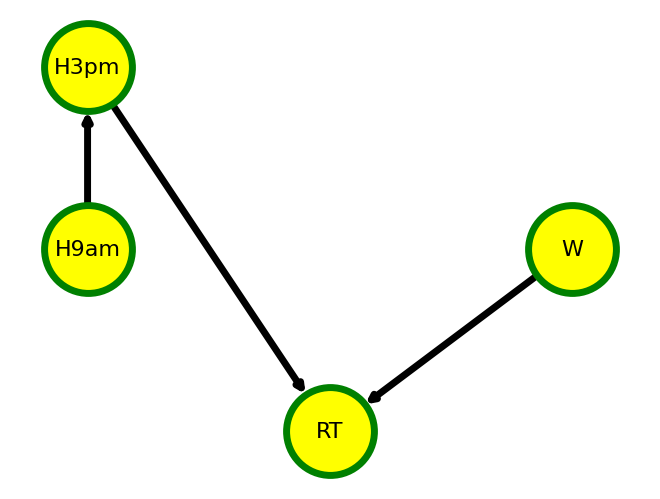

In [11]:
# Creating BBN network
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)
pos={0: (-1,0), 1: (-1, 0.5), 2: (1, 0), 3:(0,-0.5)}

options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "yellow",
    "edgecolors": "green",
    "edge_color": "black",
    "linewidths": 5,
    "width": 5,}

n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()